<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture BNNs (MCMC)

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

## Outline for today

* Can MCMC be applied to BNNs?
* How SGD can be modified as a sampler for neural networks? 

**Reading material**: This notebook + (Bayesian perspective of ANNs in Chapter 29)

## Recap: Hamiltonian Monte Carlo (HMC)

- A Hamiltonian mechanical system can be imagined as a ball rolling in a frictionless bowl

- By updating the new states by simulating trajectories shown in the figure

- This **efficiently explores** the target distribution and **increases acceptance rates** by following energy-preserving paths.
<img src="figures/hmc.png" title="Hamiltonian mechanics" width="30%" align="center">
<!-- <img align=center src="./figures/hmc.png" width=20%>  -->



In [39]:
import torch 
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import grad
import warnings
warnings.filterwarnings("ignore")
# recap the code for Hamiltonian Monte Carlo
class HMC:
    def __init__(self,
                 neg_log_prob,
                 num_dim,
                 step_size=0.1,
                 leapfrog_steps=10,
                 num_samples=100,
                 burn_in=10,
                 device='cpu'):
    
        self.neg_log_prob = neg_log_prob
        self.step_size = step_size
        self.leapfrog_steps = leapfrog_steps
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.device = device
        self.num_dim = num_dim

    def potential_energy(self, x):
        """ calculate the potential energy, i.e., negative log likelihood
        """
        return self.neg_log_prob(x)

    def kinetic_energy(self, p):
        """calculate the kinetic energy of the system, assuming unit mass.
        """
        return 0.5 * torch.sum(p ** 2)

    def grad_potential_energy(self, x):
        """calculate the gradient of the potential energy using autograd.
        """
        x = x.clone().detach().requires_grad_(True)
        U = self.potential_energy(x)
        grad_U = grad(U, x, create_graph=False)[0]
        return grad_U

    def leapfrog(self, x, p):
        # get the initial position and momentum
        x = x.clone()
        p = p.clone()
        # update half step for momentum
        p -= 0.5 * self.step_size * self.grad_potential_energy(x)
        # perform leapfrog steps
        for i in range(self.leapfrog_steps):
            # a full step for position
            x += self.step_size * p
            if i != self.leapfrog_steps - 1:
                # a full step for momentum
                p -= self.step_size * self.grad_potential_energy(x)
        # update the momentum for the last step
        p -= 0.5 * self.step_size * self.grad_potential_energy(x)
        return x, -p

    def sample(self, init_position: torch.Tensor = None):
        """Sample from the posterior distribution using Hamiltonian Monte Carlo.
        """
        self.chain_nll= []
        self.chain_samples = []
        samples = []
        accept_count = 0
        # get initial position
        if init_position is None:
            x = torch.randn(self.num_dim, device=self.device)
        else:
            x = init_position.to(self.device)

        for i in range(self.num_samples + self.burn_in):

            x = x.detach()
            p = torch.randn(self.num_dim, device=self.device)
            cur_U = self.potential_energy(x)
            cur_K = self.kinetic_energy(p)
            x_prop, p_prop = self.leapfrog(x, p)
            prop_U = self.potential_energy(x_prop)
            prop_K = self.kinetic_energy(p_prop)
            # Metropolis acceptance criterion
            accept_prob = torch.exp(cur_U - prop_U + cur_K - prop_K)
            if torch.rand(1, device=self.device) < accept_prob:
                x = x_prop
                accepted = True
            else:
                accepted = False
            if i >= self.burn_in:
                samples.append(x.cpu().numpy())
                if accepted:
                    accept_count += 1
            self.chain_nll.append(self.potential_energy(x).item())
            self.chain_samples.append(x.cpu().numpy())
        self.acceptance_rate = accept_count / self.num_samples
        return torch.tensor(samples), self.acceptance_rate
    
    def get_chain_samples(self):
        """Get the chain samples of the whole chain.
        """
        return self.chain_samples

## What happens when HMC meets Neural network?



In [40]:
## Define  a one-dimensional problem 
torch.manual_seed(0)  # fix the seed
def cubic_sin(x: torch.Tensor,
              noise_std: float = 0.1) -> torch.Tensor:
    """dis continuous function with noise"""

    obj = torch.sin(6*x)**3 + torch.randn_like(x) * noise_std

    return obj.reshape((-1, 1))
# get the training samples
sample_x1 = torch.linspace(-0.8, -0.2, 16).reshape((-1, 1))
sample_x2 = torch.linspace(0.2, 0.8, 16).reshape((-1, 1))
sample_x = torch.cat([sample_x1, sample_x2], dim=0)
# scale the data
x_mean = sample_x.mean(); x_std = sample_x.std()
sample_x_scaled = (sample_x - x_mean) / x_std
# get the responses
sample_y = cubic_sin(sample_x, noise_std=0.1)
# scale the y
y_mean = sample_y.mean(); y_std = sample_y.std()
sample_y_scaled = (sample_y - y_mean) / y_std



In [41]:

# Define the BNN model
class BNN(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

def flatten_params(model):
    # flatten the params of neural network for sampling
    return torch.cat([p.view(-1) for p in model.parameters()])

def assign_params(model, flat_params):
    # assign parameter (sampled params) to nerual network
    idx = 0
    for p in model.parameters():
        numel = p.numel()
        p.data.copy_(flat_params[idx:idx+numel].view_as(p))
        idx += numel


In [42]:
class BNN_Posterior(nn.Module):
    def __init__(self, model, X, y, noise_std=1, prior_std=1.0):
        super(BNN_Posterior, self).__init__()
        self.model = model
        self.X = X
        self.y = y
        self.noise_std = noise_std
        self.prior_std = prior_std

    def forward(self, flat_params):
        assign_params(self.model, flat_params)
        y_pred = self.model(self.X)
        log_likelihood = -0.5 * torch.sum((self.y - y_pred)**2) / self.noise_std**2
        log_prior = -0.5 * torch.sum(flat_params**2) / self.prior_std**2
        return -log_likelihood -log_prior

In [43]:

# Define model and target
input_dim = 1
hidden_dim = 256
output_dim = 1
model = BNN(input_dim, hidden_dim, output_dim)
neg_log_posterior = BNN_Posterior(model,
                    sample_x_scaled,
                    sample_y_scaled, noise_std=0.1/y_std.item(), prior_std=1.0)
param_dim = sum(p.numel() for p in model.parameters())
init_params = flatten_params(model).detach()


In [44]:
# count the number of parameters
print(f'Number of parameters in the model: {param_dim}')

Number of parameters in the model: 66561


In [45]:
# Run HMC sampling, play with those parameters
hmc = HMC(neg_log_posterior,
          num_dim=param_dim,
          step_size=0.001,
          leapfrog_steps=20,
          num_samples=1000, 
          burn_in=500)
samples, acc_rate = hmc.sample(init_position=init_params)

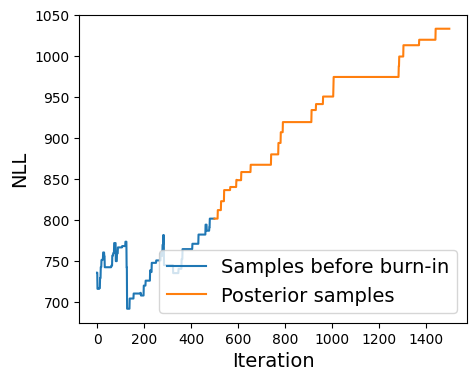

In [46]:

# plot the nll of whole samples 
plt.figure(figsize=(5,4))
plt.plot(np.arange(500), hmc.chain_nll[:500], label='Samples before burn-in')
plt.plot(np.arange(500, 1500), hmc.chain_nll[500:], label='Posterior samples')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('NLL', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [47]:
X_test = torch.linspace(-1, 1, 100).reshape((-1, 1))
y_test = cubic_sin(X_test, noise_std=0)  # ground truth
# scale the test data
X_test_scaled = (X_test - x_mean) / x_std
preds = []
for theta in samples: 
    assign_params(model, torch.tensor(theta, dtype=torch.float32))
    with torch.no_grad():
        pred = model(X_test_scaled)
        # scale the prediction back
        pred = pred * y_std + y_mean
        preds.append(pred.numpy())
preds = np.stack(preds) 
mean_pred = preds.mean(axis=0)
std_pred = preds.std(axis=0)

In [48]:
def plot_prediction():
    # plot the predictions
    fig, ax = plt.subplots(figsize=(5, 4))

    ax.plot(X_test.numpy(), y_test.numpy(), '--', linewidth=2, color='gray',label='True Function')
    ax.plot(X_test.numpy(), pred,  linewidth=2, color="blue", label='Predicted Mean')
    ax.fill_between(X_test.numpy().flatten(),
                    pred.flatten() - 2 * np.sqrt(std_pred.flatten()),
                    pred.flatten() + 2 * np.sqrt(std_pred.flatten()),
                    color="blue",
                     edgecolor=None,
                      alpha=0.2,  linewidth=2, label='Epistemic Uncertainty')
    # scale the training data
    ax.scatter(sample_x, 
            sample_y, 
            color="red", marker='o', s=40, label='Training Data')
    # set the ticks and labels
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.set_yticks(np.arange(-3, 2.1, 1.0))
    # set the font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    # set the labels
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    plt.legend(fontsize=12, loc='lower left')
    # save the figure
    # set pad
    plt.tight_layout(pad=0.1)

    plt.show()

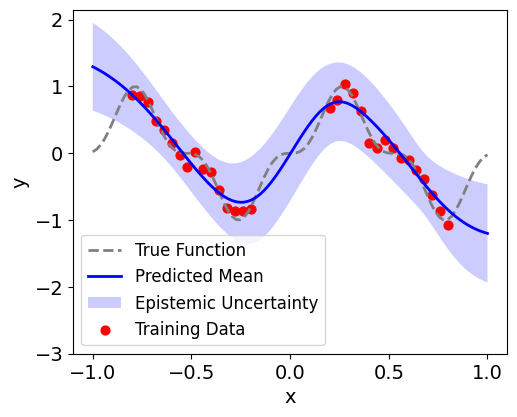

In [49]:
plot_prediction()

### See you next class

Have fun!